In [61]:
from keras.utils import image_dataset_from_directory, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental.preprocessing import Rescaling

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import cv2

Константы

In [38]:
# IMAGE_SIZE = (64, 64)
IMAGE_SIZE = (150, 150)

In [39]:
train_path = '../dataset/chest_xray/train'
val_path = '../dataset/chest_xray/val'
test_path = '../dataset/chest_xray/test'

In [42]:
labels = ['PNEUMONIA', 'NORMAL']
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, IMAGE_SIZE) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [44]:
train = get_training_data(train_path)
test = get_training_data(test_path)
val_dataset = get_training_data(val_path)

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\user\AppData\Local\Temp\ipykernel_5348\1491243153.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



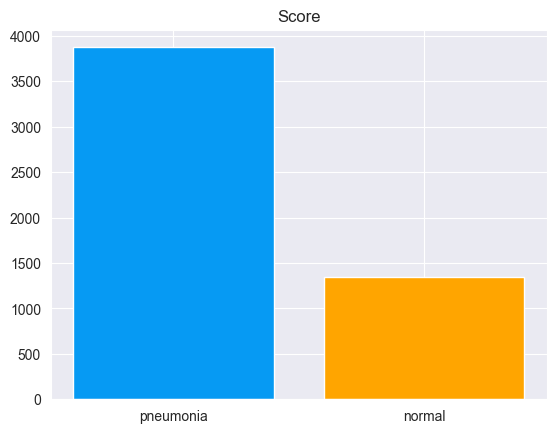

In [48]:
pneumo = 0
norm = 0
for i in train:
    if(i[1] == 0):
        pneumo += 1
    else:
        norm += 1

plt.bar(['pneumonia', 'normal'], [pneumo, norm], color=['#069AF3', 'orange'])
plt.title('Score')
plt.show()

In [50]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_dataset:
    x_val.append(feature)
    y_val.append(label)

Нормализация датасета

In [51]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [52]:
img_size = 150
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

Аугментация

In [53]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [54]:
datagen.fit(x_train)

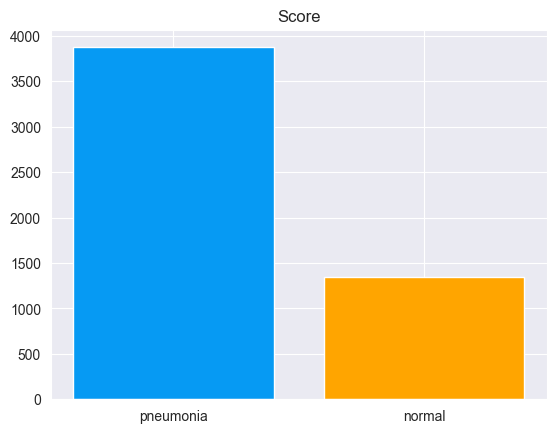

In [57]:
pneumo = 0
norm = 0
for i in y_train:
    if(i == 0):
        pneumo += 1
    else:
        norm += 1

plt.bar(['pneumonia', 'normal'], [pneumo, norm], color=['#069AF3', 'orange'])
plt.title('Score')
plt.show()

Создание модели

In [58]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

Компиляция модели

In [59]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [62]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 348s 2s/step - loss: 0.5493 - accuracy: 0.8461 - val_loss: 12.4587 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 391s 2s/step - loss: 0.2802 - accuracy: 0.8963 - val_loss: 34.1269 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9164
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 407s 2s/step - loss: 0.2245 - accuracy: 0.9164 - val_loss: 53.7878 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 410s 3s/step - loss: 0.1586 - accuracy: 0.9454 - val_loss: 0.8195 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 358s 2s/step - loss: 0.1289 - accuracy: 0.9548 - val_loss: 2.3171 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/12
163/163 [============================

In [67]:
train_acc = model.evaluate(x_train,y_train)[1] * 100
test_acc = model.evaluate(x_test,y_test)[1] * 100

20/20 [==============================] - 9s 443ms/step - loss: 0.2391 - accuracy: 0.9199


In [68]:
def score_plot():
    plt.bar(['train', 'test'], [train_acc, test_acc], color=['#069AF3', 'orange'])
    plt.title(f'Score')
    plt.show()

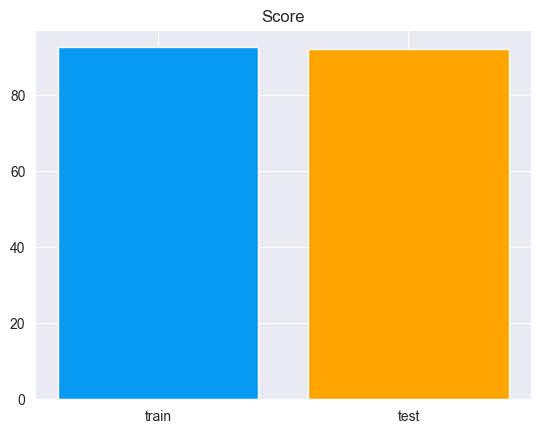

In [69]:
score_plot()

Сохранение модели

In [72]:
test_score = int(round(test_acc, 0))

model.save(f"../models/cnn{test_score}.h5")